In [1]:
#Basic Functions
import numpy as np 
import pandas as pd 
from collections import Counter

#Undersampling Techniques
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import NearMiss 

#Tree Printing 
from pprint import pprint

In [2]:
#Pull out the raw data
def fetchRawDataset() : 
    dataset = pd.read_csv('../input/restaurant-model-dataset/Dataset.csv')
    return dataset

In [3]:
#Pick out the features
#Features: ["is_open", "stars", "American", "Mexican", "Italian", "Japanese", "Chinese", "Thai", "Mediterranean", "French","Vietnamese", "Greek", "Indian", "Korean", "Hawaiian", "African", "Spanish", "Middle Eastern", "Other", "age", "review_count_16_19", "review_normalized", "pos", "neg", "neutral", "pos_norm", "neg_norm", "neutral_norm", "bi_goodfood_text", "bi_goodloc_text", "bi_bad_text", "Delivery", "RestaurantsPriceRange2", "OutdoorSeating", "HasTV", "Touristy", "Hipster", "Romantic", "Divey", "Intimate", "Trendy", "Upscale", "Classy", "Casual", "Alc_None_served", "Alc_beer_and_wine", "Alc_full_bar", "open_breakfast", "open_lunch", "open_dinner", "open_hours_meals", "displayed_open_hours", "is_crowded", "is_chain", "operation_years"]
def featureSelection(dataset) : 
    #Shorter Version: Ratings, Restaurant Category, Open Hours, Crowded, Chain
    chosen_features = ["stars", "American", "Mexican", "Italian", "Japanese", "Chinese", "Thai", "Mediterranean", "French","Vietnamese", "Greek", "Indian", "Korean", "Hawaiian", "African", "Spanish", "Middle Eastern", "Other", "open_breakfast", "open_lunch", "open_dinner", "is_crowded", "is_chain", "is_open"]
    return dataset[chosen_features]

In [4]:
#Set feature types
def assignTypes(dataset, newDataset = pd.DataFrame()) : 
    for feature in dataset.columns : 
        if dataset[feature].nunique() <= 4 : 
            newDataset[feature] = dataset[feature].astype("category").copy()
        else : 
            newDataset[feature] = dataset[feature]
    return newDataset

In [5]:
#Flip the target variable
def flipClass(dataset) :
    new_mappings = { 0 : 1, 1 : 0 }
    dataset["is_open"].replace(new_mappings, inplace=True)
    return dataset

In [6]:
#Balancethe dataset
def NCRSampling(dataset) : 
    undersample = NeighbourhoodCleaningRule(n_neighbors = 3, threshold_cleaning = 0.1)
    features, labels = undersample.fit_resample(dataset.drop(["is_open"], axis = 1), dataset["is_open"])
    features["is_open"] = labels
    return features

def NearMissSampling(dataset) :
    undersample = NearMiss(version=3, n_neighbors_ver3=3)
    features, labels = undersample.fit_resample(dataset.drop(["is_open"], axis = 1), dataset["is_open"]) 
    features["is_open"] = labels
    return features

In [7]:
#Preprocess the dataset
def fetchDataset() : 
    dataset = fetchRawDataset() #Get initial dataset
    dataset = featureSelection(dataset) #Feature selection
    dataset = assignTypes(dataset) #Type allocation
    dataset = flipClass(dataset) #Set target variable
    
    imbalanced_dataset = NCRSampling(dataset.copy())
    balanced_dataset = NearMissSampling(dataset.copy())
    
    return dataset, imbalanced_dataset, balanced_dataset

In [8]:
#Fetch Model Dataset
debug_dataset, imbalanced_dataset, balanced_dataset = fetchDataset()
print("Debugging Set  : ", Counter(debug_dataset["is_open"]))
print("Unbalanced Set : ", Counter(imbalanced_dataset["is_open"]))
print("Balanced Set   : ", Counter(balanced_dataset["is_open"]))

Debugging Set  :  Counter({0: 2301, 1: 582})
Unbalanced Set :  Counter({0: 1582, 1: 582})
Balanced Set   :  Counter({0: 582, 1: 582})


In [9]:
#Debugging dataset
from sklearn.model_selection import train_test_split

def dataset_split(dataset, test_size = 0.2) :
    X_train, X_test = train_test_split(dataset, test_size = test_size)
    return X_train.reset_index(drop = True), X_test.reset_index(drop = True)

#For Debugging
debug_training_fold, debug_testing_fold = dataset_split(debug_dataset)
print("Training Shape:", debug_training_fold.shape, "\tTesting Shape:", debug_testing_fold.shape)

Training Shape: (2306, 24) 	Testing Shape: (577, 24)


In [10]:
#Entropy - Splitting criterion
def entropy(feature, debugging = 0) : 

    entropy = 0
    values, counts = np.unique(feature, return_counts = True) #Get unique feature value and their counts    
    
    for i in range(len(values)) : 
        entropy += - (counts[i]/np.sum(counts)) * (np.log2(counts[i]/np.sum(counts))) #Entropy formula
    
    if debugging == 1 : 
        print("Number of Unique feature values: ", len(values))
        for i, j in zip(values, counts) : 
            print(i, " ==> ", j)
        print("Entropy: ", entropy)
        
    return entropy

#entropy(debug_training_fold["stars"], 1) #For Debugging

In [11]:
#Information Gain - Category
def Information_Gain(current_dataset, feature_name, target_variable = "is_open", debugging = 0) : 
    
    if debugging == 1 :
        print("\nParent Entropy: ")
    entropy_dataset = entropy(current_dataset[target_variable], debugging) #Dataset entropy
    
    #Feature Weighted entropy
    entropy_feature = 0
    values, counts = np.unique(current_dataset[feature_name], return_counts = True) #Get unique feature values and their counts 
    
    for i in range(len(values)) : 
        if debugging == 1 : 
            print("\nFeature Name: ", feature_name, "\tValue: ", values[i], "\tCount: ", counts[i])
        entropy_feature_value = entropy(current_dataset.where(current_dataset[feature_name] == values[i]).dropna()[target_variable], debugging)
        entropy_feature += counts[i] / np.sum(counts) * entropy_feature_value #Entropy becomes weighted based on the count of a particular value
    
    Information_Gain = entropy_dataset - entropy_feature
    if debugging == 1 : 
        print("\nParent Entropy: ", entropy_dataset, "\tFeature '", feature_name, "' Weighted Entropy: ", entropy_feature)
        print("Information Gain: ", Information_Gain)
        
    return Information_Gain

#Information_Gain(debug_training_fold, "American", debugging = 1) #For Debugging

In [12]:
#Information Gain - Continuous
def Count_Information_Gain(current_dataset, feature_name, target_variable = "is_open", debugging = 0, threshold = 0) : 
    
    values = sorted(current_dataset[feature_name].unique()) #Checking each value for best binary split
    
    best_IG = best_split = 0

    if debugging == 1 :
        print("\nContinuous feature found:")
    
    for i in values : #Visualizing the dataset as categorical w.r.t each value <>
        idx = current_dataset[current_dataset[feature_name] <= i].index
        temp_dataset = current_dataset.copy()
        temp_dataset[feature_name] = ">" + str(i)
        temp_dataset.loc[idx, feature_name] = "<=" + str(i)        
                
        Info_Gain = Information_Gain(temp_dataset, feature_name, target_variable, debugging)
        if Info_Gain >= best_IG : 
            best_split = i
            best_IG = Info_Gain 
            best_dataset = temp_dataset.copy()
        
    if debugging == 1 and threshold == 0 :  
        print("\nBest Split Point: ", best_split)

    if threshold == 1 : #To get the best split point
        return best_split 
    
    return best_IG, best_dataset #Information Gain & Categorical Feature

#Count_Information_Gain(debug_training_fold, "stars", debugging = 1) #For Debugging

In [13]:
#Gain Ratio
def Gain_Ratio(current_dataset, feature_name, target_variable = "is_open", debugging = 0) : 
    
    if current_dataset[feature_name].dtype.name != "category" : #For Continuous values
        Info_Gain, temp_dataset = Count_Information_Gain(current_dataset, feature_name, target_variable, debugging)        
        Split_Info = entropy(temp_dataset[feature_name], debugging)
    
    else : #For Categorical values
        Info_Gain = Information_Gain(current_dataset, feature_name, target_variable, debugging)
        Split_Info = entropy(current_dataset[feature_name], debugging)
    
    Gain_Ratio = Info_Gain / (Split_Info + 0.1) #To face the zero entropy problem
    
    if debugging == 1 : 
        print("\nInformation Gain: ", Info_Gain, "\tFeature '", feature_name, "' Split Info (Entropy): ", Split_Info)
        print("Gain Ratio: ", Gain_Ratio)

    return Gain_Ratio

#Gain_Ratio(debug_training_fold, "American", debugging = 1) #For Debugging

In [14]:
#DTree Construction
def C4_5(current_dataset, orginal_dataset, features, target_variable = "is_open", parent_node_label = None, debugging = 0, max_height = 10) :
    
    if len(np.unique(current_dataset[target_variable])) == 1  : #If the target_varible is pure return the label
        return np.unique(current_dataset[target_variable])[0]
    
    elif len(current_dataset) == 0 : #If dataset is empty, return the mode target feature value in the original dataset
        return np.unique(orginal_dataset[target_variable])[np.argmax(np.unique(orginal_dataset[target_variable], return_counts = True)[1])]
    
    elif len(features) == 0 : #If feature list is empty return the label
        return parent_node_label
    
    elif max_height == -1 : 
        return np.unique(current_dataset[target_variable])[np.argmax(np.unique(current_dataset[target_variable], return_counts = True)[1])]
    
    else: #Tree Construction
        #Set the default value for this node --> The mode target feature value of the current node
        parent_node_label = np.unique(current_dataset[target_variable])[np.argmax(np.unique(current_dataset[target_variable], return_counts = True)[1])]

        #Choosing the feature that gives the best split
        GR_values = []
        for feature in features : 
            GR_values.append(Gain_Ratio(current_dataset,feature))
        best_feature = features[np.argmax(GR_values)]

        #Choosing the best feature as the root node
        tree = { best_feature : { }, "gain_ratio" : max(GR_values), "sample_count" : len(current_dataset.index), "values" : [], "class" : parent_node_label, "confidence" : { }, "leaf_values" : {} }
        
        pos_count = len(current_dataset[current_dataset["is_open"] == 1].index)
        neg_count = len(current_dataset[current_dataset["is_open"] == 0].index)
        tree["values"] = [pos_count, neg_count]
        
        if current_dataset[best_feature].dtype.name != "category" : 
                       
            split_point = Count_Information_Gain(current_dataset, best_feature, target_variable, debugging, threshold = 1)
                        
            sub_dataset = current_dataset.where(current_dataset[best_feature] <= split_point).dropna() #Choosing the points belonging to feature value
            sub_tree = C4_5(sub_dataset, orginal_dataset, features, target_variable, parent_node_label, debugging, max_height - 1) #Recursive construction
            tree[best_feature]["<=" + str(split_point)] = sub_tree  #Add the sub tree, grown from the sub_dataset to the tree under the root node
            if type(sub_tree) is not dict :
                if len(sub_dataset.index) == 0 : 
                    positive_class_prob = len(current_dataset.loc[current_dataset[target_variable] == 1].index) / len(current_dataset.index) 
                else : 
                    positive_class_prob = len(sub_dataset.loc[sub_dataset[target_variable] == 1].index) / len(sub_dataset.index)  
                tree["confidence"]["<=" + str(split_point)] = positive_class_prob
                pos_count = len(sub_dataset[sub_dataset["is_open"] == 1].index)
                neg_count = len(sub_dataset[sub_dataset["is_open"] == 0].index)
                tree["leaf_values"]["<=" + str(split_point)] = [pos_count, neg_count] 
            
            sub_dataset = current_dataset.where(current_dataset[best_feature] > split_point).dropna() #Choosing the points belonging to feature value
            sub_tree = C4_5(sub_dataset, orginal_dataset, features, target_variable, parent_node_label, debugging, max_height - 1) #Recursive construction
            tree[best_feature][">" + str(split_point)] = sub_tree  #Add the sub tree, grown from the sub_dataset to the tree under the root node
            if type(sub_tree) is not dict :
                if len(sub_dataset.index) == 0 : 
                    positive_class_prob = len(current_dataset.loc[current_dataset[target_variable] == 1].index) / len(current_dataset.index) 
                else : 
                    positive_class_prob = len(sub_dataset.loc[sub_dataset[target_variable] == 1].index) / len(sub_dataset.index)  
                tree["confidence"][">" + str(split_point)] = positive_class_prob
                pos_count = len(sub_dataset[sub_dataset["is_open"] == 1].index)
                neg_count = len(sub_dataset[sub_dataset["is_open"] == 0].index)
                tree["leaf_values"][">" + str(split_point)] = [pos_count, neg_count] 
            
        else : 
            
            #Removing the best feature from the list
            features = [ i for i in features if i != best_feature ]

            #Branching for each feature value
            for value in np.unique(current_dataset[best_feature]) :
                sub_dataset = current_dataset.where(current_dataset[best_feature] == value).dropna() #Choosing the points belonging to feature value
                sub_tree = C4_5(sub_dataset, orginal_dataset, features, target_variable, parent_node_label, debugging, max_height - 1) #Recursive construction  
                tree[best_feature][value] = sub_tree  #Add the sub tree, grown from the sub_dataset to the tree under the root node
                if type(sub_tree) is not dict:
                    if len(sub_dataset.index) == 0 : 
                        positive_class_prob = len(current_dataset.loc[current_dataset[target_variable] == 1].index) / len(current_dataset.index) 
                    else : 
                        positive_class_prob = len(sub_dataset.loc[sub_dataset[target_variable] == 1].index) / len(sub_dataset.index)  
                    tree["confidence"][value] = positive_class_prob 
                    pos_count = len(sub_dataset[sub_dataset["is_open"] == 1].index)
                    neg_count = len(sub_dataset[sub_dataset["is_open"] == 0].index)
                    tree["leaf_values"][value] = [pos_count, neg_count] 
        return tree  

Debug_Tree = C4_5(debug_training_fold, debug_training_fold, debug_training_fold.columns[:-1], max_height = 10) #For Debugging
#pprint(Debug_Tree)

In [15]:
#DTree Traversal
def Predict(datapoint, decision_tree, getProb = 0, debugging = 0):
    
    probability = 0 
    continuous_features = ["stars", "review_count_16_19", "pos", "neg", "neutral", "bi_goodfood_text", "bi_goodloc_text", "bi_bad_text"] #Continuous Features

    for key in list(datapoint.keys()):
        
        if key in list(decision_tree.keys()):
            
            if key in continuous_features : #Continuous Feature
                                
                if list(decision_tree[key].keys())[0][0] == "<" : 
                    threshold = float(list(decision_tree[key].keys())[0][2:])
                else : 
                    threshold = float(list(decision_tree[key].keys())[0][1:])
                
                if datapoint[key] <= threshold : 
                    sub_tree = decision_tree[key]["<=" + str(threshold)]
                    if type(sub_tree) is not dict : 
                        if getProb : probability = decision_tree["confidence"]["<=" + str(threshold)]
                    
                    if debugging == 1 : 
                        print("\nContinuous Feature: ", key, "\tSplit Threshold: <=", threshold)
                        print("\nResult after Traversal: ", sub_tree)
                else : 
                    sub_tree = decision_tree[key][">" + str(threshold)]
                    if type(sub_tree) is not dict : 
                        if getProb : probability = decision_tree["confidence"][">" + str(threshold)]
                    
                    if debugging == 1 : 
                        print("\nContinuous Feature: ", key, "\tSplit Threshold: >", threshold)
                        print("\nResult after Traversal: ", sub_tree)
                            
            else : #Categorical Feature
                sub_tree = decision_tree[key][datapoint[key]]
                if type(sub_tree) is not dict : 
                    if getProb : probability = decision_tree["confidence"][datapoint[key]] 
                
                if debugging == 1 : 
                    print("\nCategorical Feature: ", key, "\tSplit Value: ", datapoint[key])
                    print("\nResult after Traversal: ", sub_tree)
                    
            if isinstance(sub_tree, dict):
                return Predict(datapoint, sub_tree, getProb, debugging) #If subtree is dictionary, recursive call
            
            else: #If subtree is a leaf, return label
                if getProb == 1 : 
                    return probability
                return sub_tree
            
#debug_query = {'stars': 4.5, 'American': 1, 'Mexican': 0, 'Italian': 0, 'Japanese': 0, 'Chinese': 0, 'Thai': 0, 'Mediterranean': 0, 'French': 0, 'Vietnamese': 0, 'Greek': 0, 'Indian': 0, 'Korean': 0, 'Hawaiian': 0, 'African': 0, 'Spanish': 0, 'Middle Eastern': 0, 'Other': 0, 'open_breakfast': 0, 'open_lunch': 1, 'open_dinner': 0, 'is_crowded': 0, 'is_chain': 0}
#Predict(debug_query, Debug_Tree, getProb = 1, debugging = 1) #Debugging

In [16]:
#Testing classifier
def Validation(testing_values, decision_tree, debugging = 0):
    
    datapoints = testing_values.iloc[:,:-1].to_dict(orient = "records") #Converting each datapoint into a dict
    predicted = pd.DataFrame(columns=["pred_value", "pred_probability"]) #To store the predicted labels
    for i in range(len(testing_values)):
        predicted.loc[i, "pred_value"] = Predict(datapoints[i], decision_tree, debugging) 
        predicted.loc[i, "pred_probability"] = Predict(datapoints[i], decision_tree, getProb = 1) 
        
    return predicted

debug_actual_labels = list(debug_testing_fold["is_open"]) #For Debugging
debug_pred_labels = list(Validation(debug_testing_fold, Debug_Tree)["pred_value"]) 
debug_pred_probs = list(Validation(debug_testing_fold, Debug_Tree)["pred_probability"])

In [17]:
#Classifer Statistics - Confusion Matrix
def Confusion_Matrix(actual_labels, predicted_labels) : 
    
    TP = TN = FP = FN = 0
    
    for i, j in zip(actual_labels, predicted_labels) : 
        if i == j and i == 1 :   #True Positive
            TP += 1
        elif i == j and i == 0 : #True Negative
            TN += 1
        elif i != j and i == 0 : #False Positive 
            FP += 1
        elif i != j and i == 1 : #False Negative
            FN += 1
            
    return TP, TN, FP, FN

debug_TP, debug_TN, debug_FP, debug_FN = Confusion_Matrix(debug_actual_labels, debug_pred_labels) #For Debugging
#print("True Positive: ", TP, "\tFalse Negative: ", FN)
#print("False Positve: ", FP, "\tTrue Negative: ", TN)

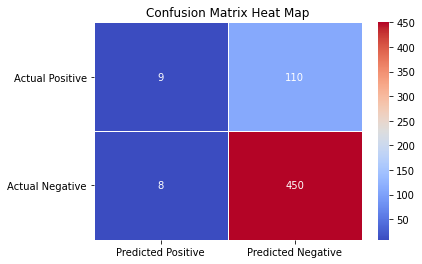

In [18]:
#Confusion Matrix Heat Map
import matplotlib.pyplot as plt
import seaborn as sns

def CM_Heat_Map(actual_labels, predicted_labels, filename) : 
    
    TP, TN, FP, FN = Confusion_Matrix(actual_labels, predicted_labels)
    HM_Value = np.asarray([TP, FN, FP, TN]).reshape(2, 2)
    x_axis_labels = ["Predicted Positive", "Predicted Negative"] # labels for x-axis
    y_axis_labels = ["Actual Positive", "Actual Negative"]       # labels for y-axis
    heatmap = sns.heatmap( HM_Value , annot=True, fmt = ".3g", linewidth = 0.5 , cmap = 'coolwarm', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.yticks(rotation = 0) 
    plt.title( "Confusion Matrix Heat Map" )
    plt.savefig(filename + " CMHM.png")
    plt.show()

CM_Heat_Map(debug_actual_labels, debug_pred_labels, "Debugging") #For Debugging

In [19]:
#Classifer Statistics - Accuracy
def Metric_Accuracy(TP, TN, FP, FN) : 
    
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    return Accuracy

print("Accuracy: ", Metric_Accuracy(debug_TP, debug_TN, debug_FP, debug_FN) * 100) #For Debugging*

Accuracy:  79.54939341421144


In [20]:
#Classifer Statistics - Precision, Recall & F-Score
def Metric_FMeasure(TP, TN, FP, FN) : 
    
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F_Score = (2 * Precision * Recall) / (Precision + Recall)
    
    return Precision, Recall, F_Score

debug_Precision, debug_Recall, debug_F_Score = Metric_FMeasure(debug_TP, debug_TN, debug_FP, debug_FN) #For Debugging
print("Precision: ", debug_Precision, "\tRecall: ", debug_Recall, "\tF-Score: ", debug_F_Score)

Precision:  0.5294117647058824 	Recall:  0.07563025210084033 	F-Score:  0.1323529411764706


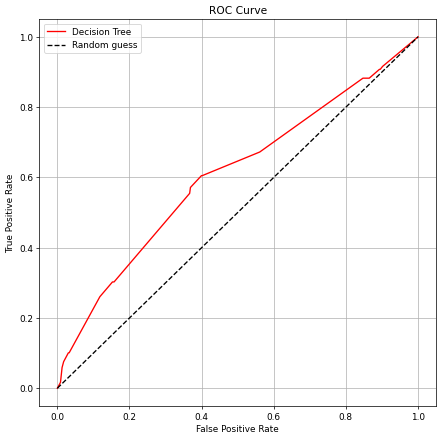

False Positive Rates:  [0.         0.00873362 0.01310044 0.01746725 0.03056769 0.03275109
 0.11790393 0.15283843 0.15720524 0.36681223 0.36899563 0.39956332
 0.40174672 0.56113537 0.84716157 0.86462882 0.8930131  0.89519651
 0.90174672 1.        ]
True Positive Rates:  [0.         0.01680672 0.05882353 0.07563025 0.10084034 0.10084034
 0.2605042  0.30252101 0.30252101 0.55462185 0.57142857 0.60504202
 0.60504202 0.67226891 0.88235294 0.88235294 0.90756303 0.90756303
 0.91596639 1.        ]


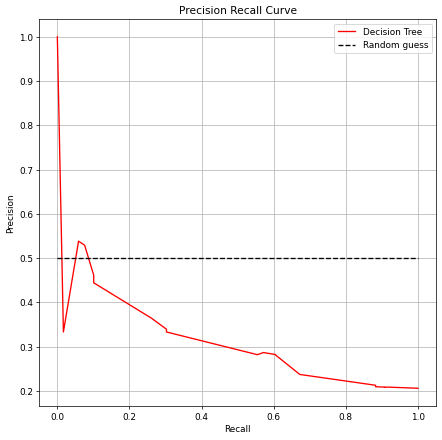

Precision Rates:  [0.20623917 0.20881226 0.20849421 0.20889749 0.20958084 0.21298174
 0.23738872 0.28125    0.28235294 0.28691983 0.28205128 0.33333333
 0.33962264 0.36470588 0.44444444 0.46153846 0.52941176 0.53846154
 0.33333333 1.        ]
Recall Rates:  [1.         0.91596639 0.90756303 0.90756303 0.88235294 0.88235294
 0.67226891 0.60504202 0.60504202 0.57142857 0.55462185 0.30252101
 0.30252101 0.2605042  0.10084034 0.10084034 0.07563025 0.05882353
 0.01680672 0.        ]


In [21]:
#Plotting Graphs
from sklearn import metrics

def ROC_Curve(actual_labels, predicted_probs, filename) :  

    false_positive_rates, true_positive_rates, thresholds = metrics.roc_curve(actual_labels, predicted_probs, pos_label = 1)
    plt.figure(dpi=64, figsize=(8,8))
    plt.plot(false_positive_rates, true_positive_rates, linestyle='-', label='Decision Tree', color = "red")
    plt.plot([0, 1], [0, 1], "k--", label='Random guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(filename + " ROCCurve.png")
    plt.show()
    print("False Positive Rates: ", false_positive_rates)
    print("True Positive Rates: ", true_positive_rates)
    
def PR_Curve(actual_labels, predicted_probs, filename) :  

    precision_rates, recall_rates, thresholds = metrics.precision_recall_curve(actual_labels, predicted_probs, pos_label = 1)
    plt.figure(dpi=64, figsize=(8,8))
    plt.plot(recall_rates, precision_rates, linestyle='-', label='Decision Tree', color = "red")
    plt.plot([0, 1], [0.5, 0.5], "k--", label='Random guess')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(filename + " PRCurve.png")
    plt.show()
    print("Precision Rates: ", precision_rates)
    print("Recall Rates: ", recall_rates)

ROC_Curve(debug_actual_labels, debug_pred_probs, "Debugging")
PR_Curve(debug_actual_labels, debug_pred_probs, "Debugging")

Accuracy :  0.6051502145922747


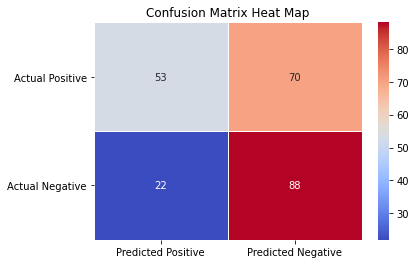

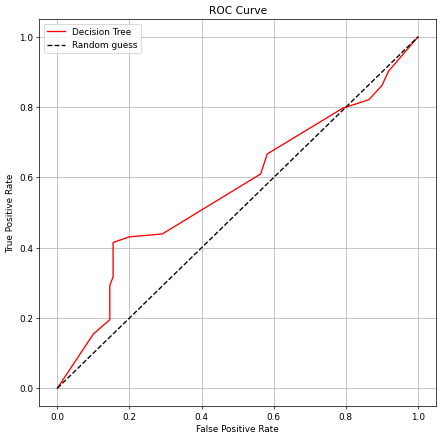

False Positive Rates:  [0.         0.1        0.14545455 0.14545455 0.14545455 0.15454545
 0.15454545 0.15454545 0.15454545 0.2        0.29090909 0.56363636
 0.58181818 0.79090909 0.86363636 0.9        0.91818182 1.        ]
True Positive Rates:  [0.         0.15447154 0.19512195 0.26829268 0.29268293 0.31707317
 0.32520325 0.35772358 0.41463415 0.43089431 0.43902439 0.6097561
 0.66666667 0.79674797 0.82113821 0.86178862 0.90243902 1.        ]


In [22]:
#Training balanced classifier
bal_training_fold, bal_testing_fold = dataset_split(balanced_dataset)
balanced_DTree = C4_5(bal_training_fold, bal_training_fold, bal_training_fold.columns[:-1], max_height = 10)    

bal_actual_labels = list(bal_testing_fold["is_open"]) #Fetch results
bal_pred_labels = list(Validation(bal_testing_fold, balanced_DTree)["pred_value"]) 
bal_pred_probs = list(Validation(bal_testing_fold, balanced_DTree)["pred_probability"])

bal_TP, bal_TN, bal_FP, bal_FN = Confusion_Matrix(bal_actual_labels, bal_pred_labels) #Fetch metrics
print("Accuracy : ", Metric_Accuracy(bal_TP, bal_TN, bal_FP, bal_FN))

CM_Heat_Map(bal_actual_labels, bal_pred_labels, "Balanced Set") #Fetch graphs
ROC_Curve(bal_actual_labels, bal_pred_probs, "Balanced Set") 

F-Measure :  (0.7583333333333333, 0.9130434782608695, 0.8285280728376327)


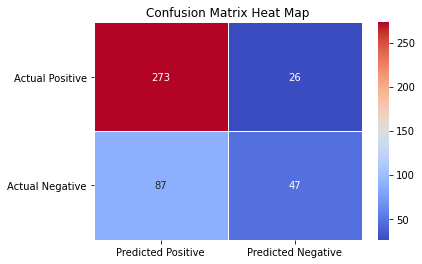

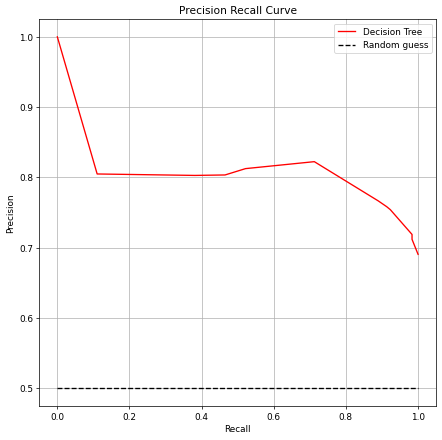

Precision Rates:  [0.69053118 0.71186441 0.71882641 0.75409836 0.75833333 0.76657061
 0.82239382 0.8125     0.80346821 0.8028169  0.80487805 0.82857143
 1.        ]
Recall Rates:  [1.         0.98327759 0.98327759 0.92307692 0.91304348 0.88963211
 0.71237458 0.52173913 0.46488294 0.3812709  0.11036789 0.09698997
 0.        ]


In [23]:
#Training imbalanced classifier
imbal_training_fold, imbal_testing_fold = dataset_split(flipClass(imbalanced_dataset))
imbalanced_DTree = C4_5(imbal_training_fold, imbal_training_fold, imbal_training_fold.columns[:-1], max_height = 10)    

imbal_actual_labels = list(imbal_testing_fold["is_open"]) #Fetch results
imbal_pred_labels = list(Validation(imbal_testing_fold, imbalanced_DTree)["pred_value"]) 
imbal_pred_probs = list(Validation(imbal_testing_fold, imbalanced_DTree)["pred_probability"])

imbal_TP, imbal_TN, imbal_FP, imbal_FN = Confusion_Matrix(imbal_actual_labels, imbal_pred_labels) #Fetch metrics
print("F-Measure : ", Metric_FMeasure(imbal_TP, imbal_TN, imbal_FP, imbal_FN))

CM_Heat_Map(imbal_actual_labels, imbal_pred_labels, "Imbalanced Set") #Fetch graphs
PR_Curve(imbal_actual_labels, imbal_pred_probs, "Imbalanced Set") 

In [24]:
#K-fold cross validation - Fetching sound metrics
from sklearn.model_selection import StratifiedKFold

def KFold_Cross_Validation(dataset, method = "balanced", max_height = 10) : 
    
    values = []
    KFModel = StratifiedKFold(n_splits = 5, random_state = 100, shuffle = True)
    for training_index, testing_index in KFModel.split(dataset, dataset["is_open"]) :

        kfold_training_values, kfold_testing_values = dataset.loc[training_index, : ], dataset.loc[testing_index, : ] 
        Kfold_DTree = C4_5(kfold_training_values, kfold_training_values, kfold_training_values.columns[:-1], max_height = max_height)
    
        kfold_actual_labels = list(kfold_testing_values["is_open"]) 
        kfold_pred_labels = list(Validation(kfold_testing_values, Kfold_DTree)["pred_value"])
        kfold_TP, kfold_TN, kfold_FP, kfold_FN = Confusion_Matrix(kfold_actual_labels, kfold_pred_labels)
        
        if method == "balanced" : 
            values.append(Metric_Accuracy(kfold_TP, kfold_TN, kfold_FP, kfold_FN))
        else :
            values.append(Metric_FMeasure(kfold_TP, kfold_TN, kfold_FP, kfold_FN)[2]) 
    
    return values

In [25]:
#Error Plot
import matplotlib.pyplot as plt
%matplotlib inline

def Error_Bars(values, metric, filename) : 

    Mean = np.mean(values)
    STD = np.std(values)
    
    #Plot Metrics
    values = [Mean]
    errors = [STD]
    labels = ["Decision Tree"]
    x_pos = np.arange(len(labels))

    # Build the plot
    fig, ax = plt.subplots(dpi=64, figsize = (5, 5))
    ax.bar(x_pos, values, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title("Metrics of Decision Tree")
    ax.yaxis.grid(True)
    plt.ylim([0.0, 1.0])
    plt.tight_layout()
    plt.savefig(filename + ".png")
    plt.show()
    
    print(metric, " : %.3f" %Mean, " STD : %.3f" %STD)

Accuracy Values:  [0.5965665236051502, 0.6223175965665236, 0.592274678111588, 0.575107296137339, 0.6163793103448276]


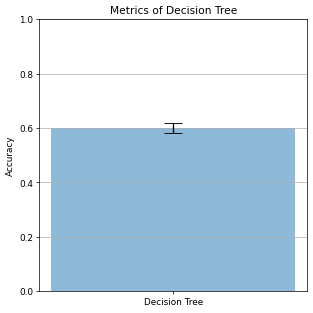

Accuracy  : 0.601  STD : 0.017


In [26]:
#Fetching Balanced K-Fold Metrics
accuracy_values = KFold_Cross_Validation(balanced_dataset, method = "balanced", max_height = 10)
print("Accuracy Values: ", accuracy_values)
Error_Bars(accuracy_values, "Accuracy", "Balanced Accuracy Bar Plot") #Fetch Graphs

F-Measure Values:  [0.8425655976676385, 0.8622222222222222, 0.8357771260997067, 0.8330871491875922, 0.8410104011887073]


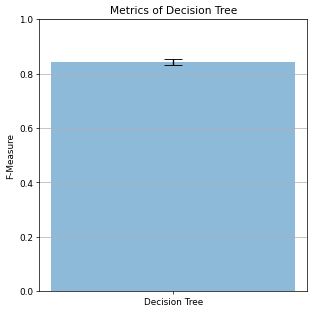

F-Measure  : 0.843  STD : 0.010


In [27]:
#Fetching Imbalanced K-Fold Metrics
fmeasure_values = KFold_Cross_Validation(imbalanced_dataset, method = "imbalanced", max_height = 10)
print("F-Measure Values: ", fmeasure_values)
Error_Bars(fmeasure_values, "F-Measure", "Imbalanced F-Measure Bar Plot") #Fetch Graphs

In [28]:
#References: 
#https://www.python-course.eu/Decision_Trees.php
#https://anderfernandez.com/en/blog/code-decision-tree-python-from-scratch/
#https://www.analyticssteps.com/blogs/what-gini-index-and-information-gain-decision-trees
#https://anderfernandez.com/en/blog/code-decision-tree-python-from-scratch/

#https://sefiks.com/2018/05/13/a-step-by-step-c4-5-decision-tree-example/
#https://sefiks.com/2017/11/20/a-step-by-step-id3-decision-tree-example/
#https://cis.temple.edu/~giorgio/cis587/readings/id3-c45.html

#https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/
#https://machinewithdata.com/2018/07/10/how-to-calculate-gain-ratio/#:~:text=Gain%20ratio%20overcomes%20the%20problem,add%20penalty%20to%20information%20gain.
#https://www.kdnuggets.com/2020/01/decision-tree-algorithm-explained.html